In [1]:
import numpy as np
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt

In [2]:
log_dir = "/Users/porterjenkins/Downloads/logs"

In [3]:
runs = os.listdir(log_dir)

In [4]:
exp_key = "Beginning experiment"
mcmd_key = "Final MCMD:"
config_key = "Data Config:"
hyper_key = "Hyperparam Config:"

In [5]:
poisson_key = "poisson"
gaussian_key = "gaussian"
ddpn_key = "ddpn"
seitzer_key = "seitzer"

In [6]:
blur_key = 'blur'
mixup_key = 'mixup'
label_noise_key = 'labelnoise'

In [7]:
dta = []
for r in runs:
    stats = []
    if r == ".DS_Store":
        continue
    fpath = os.path.join(log_dir, r, 'log.txt')
    with open(fpath, "r") as f:
        log_rows = f.readlines()    
        for i, l in enumerate(log_rows):
            if i == 0:
                if blur_key in l:
                    stats.append(blur_key)
                elif mixup_key in l:
                    stats.append(mixup_key)
                elif label_noise_key in l:
                    stats.append(label_noise_key)
                else:
                    stats.append("baseline")
            
            val = None
            if exp_key in l:
                val = l.split(exp_key)[-1].strip()
                if poisson_key in val:
                    val = poisson_key
                elif gaussian_key in val:
                    val = gaussian_key
                elif ddpn_key in val:
                    val = ddpn_key
                elif seitzer_key in val:
                    val = seitzer_key
            elif mcmd_key in l:
                val = l.split(mcmd_key)[-1].strip()
            elif config_key in l:
                val = ast.literal_eval(l.split(config_key)[-1].strip())['perturb']
                if isinstance(val, dict):
                    val = val['mean']
                elif val is None:
                    val = 0.0
            elif hyper_key in l:
                val = ast.literal_eval(l.split(hyper_key)[-1].strip())['lmbda']
            if val is not None:
                stats.append(val)
    dta.append(stats)
        

In [8]:
df = pd.DataFrame(dta, columns = ['experiment','head', 'perturb' ,'lambda', 'mcmd'])
df['mcmd'] = df['mcmd'].astype(float)

In [9]:
df[df['experiment']==label_noise_key]

experiment     head  perturb  lambda      mcmd
1    labelnoise     ddpn      3.0    0.05  0.352022
3    labelnoise     ddpn      5.0    0.05  0.577009
5    labelnoise     ddpn      1.0    0.05  0.116026
8    labelnoise  poisson      4.0    0.05  0.478687
11   labelnoise  poisson      3.0    0.05  0.361172
..          ...      ...      ...     ...       ...
429  labelnoise  poisson      2.0    0.05  0.238857
433  labelnoise     ddpn      4.0    0.05  0.472291
436  labelnoise  poisson      1.0    0.05  0.113559
440  labelnoise  poisson      4.0    0.05  0.481003
441  labelnoise  poisson      3.0    0.05  0.366203

[100 rows x 5 columns]

In [10]:
# Remove gaussian
df = df[df['head'] != gaussian_key]

In [11]:
df.to_csv("ood_exp_results.csv", index=False)

In [12]:
summary = df[['experiment','head', 'perturb', 'lambda', 'mcmd']].groupby(['experiment', 'head', 'lambda', 'perturb']).agg(['mean', 'std', 'count'])

In [13]:
summary.reset_index(inplace=True)

In [14]:
summary['head'] = summary['head'].replace(seitzer_key, r"$\beta$-Gaussian (Seitzer '22)")
summary['head'] = summary['head'].replace(ddpn_key, "DDPN (Young '24)")
summary['head'] = summary['head'].replace(poisson_key, 'Poisson')

In [15]:
summary.head()

experiment              head lambda perturb      mcmd                
                                                   mean       std count
0   baseline  DDPN (Young '24)   0.01     0.0  0.120400  0.000511     5
1   baseline  DDPN (Young '24)   0.05     0.0  0.081523  0.002625     5
2   baseline  DDPN (Young '24)   0.10     0.0  0.075788  0.002032     6
3   baseline  DDPN (Young '24)   0.50     0.0  0.056120  0.000510     3
4   baseline  DDPN (Young '24)   1.00     0.0  0.043446  0.001741     3

# Generate OOD Plots

In [16]:
def get_ood_fig(exp_data, fpath, append_xlabel=''):
    plt.figure()
    plt.figure(figsize=(6, 6))
    plt.grid(True)
    for head, head_dta in exp_data.groupby('head'):
        plt.errorbar(
            head_dta['perturb'], 
            head_dta['mcmd']['mean'], 
            yerr=head_dta['mcmd']['std'], 
            fmt='-o', 
            ecolor='black', 
            capsize=5, 
            label=head
        )
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))
    plt.legend(fontsize=14)
    plt.xlabel("Perturbation" + append_xlabel, fontsize=16)
    plt.ylabel(r"$\overline{\mathrm{CCE}}$", fontsize=16)
    plt.savefig(fpath)
    plt.show()
    plt.clf()
    plt.close()

In [17]:
lmbda = 0.05

In [18]:
blur = summary[summary['experiment'].isin(['blur']) & (summary['lambda'] == lmbda)]
mixup = summary[summary['experiment'].isin(['mixup']) & (summary['lambda'] == lmbda)]
labelnoise = summary[summary['experiment'].isin(['labelnoise']) & (summary['lambda'] == lmbda)]

<Figure size 640x480 with 0 Axes>

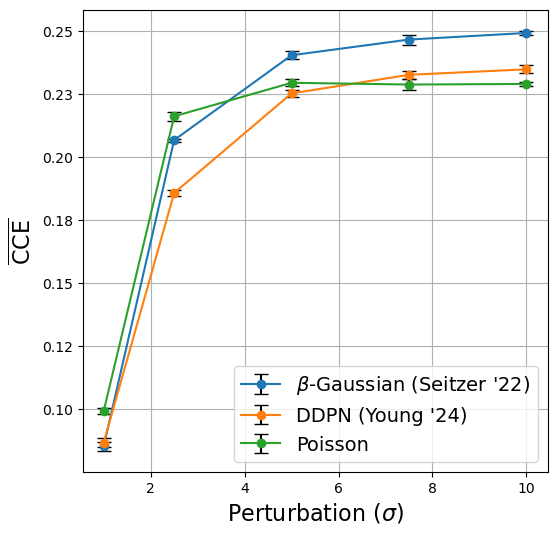

In [19]:
get_ood_fig(blur, 'ood_blur.pdf', append_xlabel=" ($\sigma$)")

<Figure size 640x480 with 0 Axes>

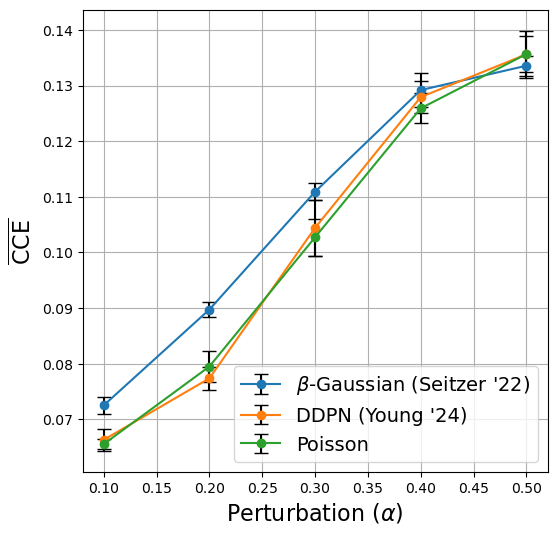

In [20]:
get_ood_fig(mixup, 'ood_mixup.pdf', append_xlabel=r' ($\alpha$)')

<Figure size 640x480 with 0 Axes>

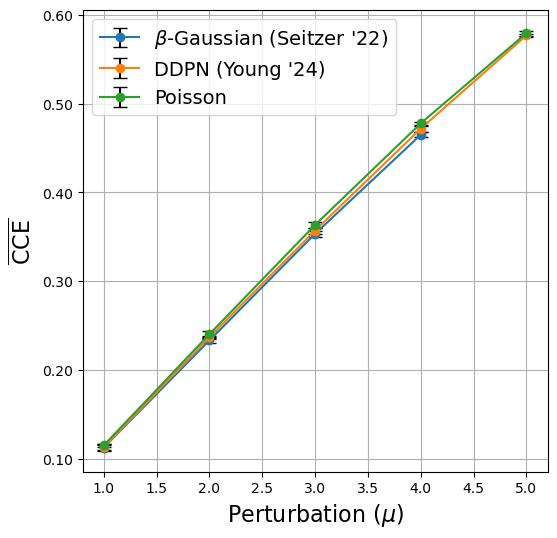

In [21]:
get_ood_fig(labelnoise, 'ood_labelnoise.pdf', append_xlabel=" ($\mu$)")

In [22]:
labelnoise

experiment                            head lambda perturb      mcmd  \
                                                                   mean   
47  labelnoise                DDPN (Young '24)   0.05     1.0  0.112943   
48  labelnoise                DDPN (Young '24)   0.05     2.0  0.236953   
49  labelnoise                DDPN (Young '24)   0.05     3.0  0.357063   
50  labelnoise                DDPN (Young '24)   0.05     4.0  0.471871   
51  labelnoise                DDPN (Young '24)   0.05     5.0  0.576913   
52  labelnoise                         Poisson   0.05     1.0  0.114959   
53  labelnoise                         Poisson   0.05     2.0  0.240273   
54  labelnoise                         Poisson   0.05     3.0  0.363378   
55  labelnoise                         Poisson   0.05     4.0  0.477793   
56  labelnoise                         Poisson   0.05     5.0  0.579423   
57  labelnoise  $\beta$-Gaussian (Seitzer '22)   0.05     1.0  0.112530   
58  labelnoise  $\beta$-Gaussian (Seitzer '22)   0.05     2.0  0.233290   
59  labelnoise  $\beta$-Gaussian (Seitzer '22)   0.05     3.0  0.353374   
60  labelnoise  $\beta$-Gaussian (Seitzer '22)   0.05     4.0  0.464963   

                    
         std count  
47  0.003105     5  
48  0.001620     5  
49  0.003424     5  
50  0.003441     5  
51  0.002121     5  
52  0.002160    10  
53  0.003663    10  
54  0.003009    10  
55  0.002112    10  
56  0.002750    10  
57  0.003492     5  
58  0.002740     5  
59  0.003368     5  
60  0.002959    10

# Effect of Lambda

In [23]:
hyperparam = df[(df['experiment'] == 'baseline')].groupby(["head","lambda"]).head(3).groupby(["head","lambda"]).agg(["mean", "std", "count"]).reset_index()

/var/folders/w5/203pqh9x1h5089n8fqdq8j3w0000gn/T/ipykernel_57760/1852842032.py:1: FutureWarning: ['experiment'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  hyperparam = df[(df['experiment'] == 'baseline')].groupby(["head","lambda"]).head(3).groupby(["head","lambda"]).agg(["mean", "std", "count"]).reset_index()


In [24]:
hyperparam

head lambda perturb                 mcmd                
                      mean  std count      mean       std count
0      ddpn   0.01     0.0  0.0     3  0.120637  0.000346     3
1      ddpn   0.05     0.0  0.0     3  0.081936  0.003327     3
2      ddpn   0.10     0.0  0.0     3  0.076575  0.002427     3
3      ddpn   0.50     0.0  0.0     3  0.056120  0.000510     3
4      ddpn   1.00     0.0  0.0     3  0.043446  0.001741     3
5      ddpn   2.50     0.0  0.0     3  0.025508  0.000953     3
6   poisson   0.01     0.0  0.0     3  0.084474  0.001137     3
7   poisson   0.05     0.0  0.0     3  0.066661  0.001956     3
8   poisson   0.10     0.0  0.0     3  0.060897  0.001197     3
9   poisson   1.00     0.0  0.0     3  0.035549  0.002203     3
10  poisson   2.50     0.0  0.0     3  0.021346  0.000145     3
11  seitzer   0.05     0.0  0.0     3  0.079842  0.001763     3

<Figure size 640x480 with 0 Axes>

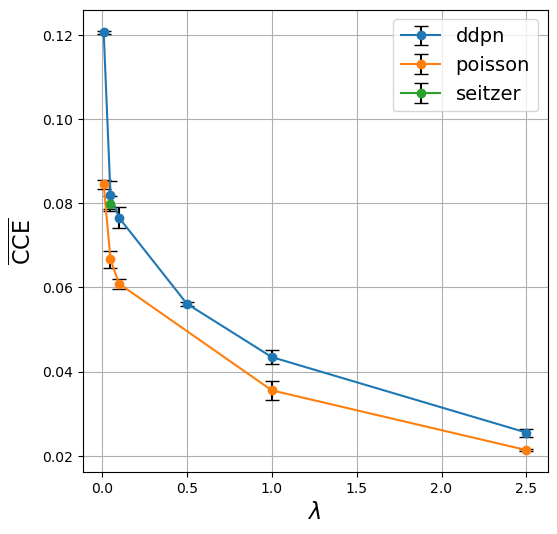

In [25]:
plt.figure()
plt.figure(figsize=(6, 6))
plt.grid(True)
for head, head_dta in hyperparam.groupby('head'):
    plt.errorbar(
        head_dta['lambda'], 
        head_dta['mcmd']['mean'], 
        yerr=head_dta['mcmd']['std'], 
        fmt='-o', 
        ecolor='black', 
        capsize=5, 
        label=head
    )
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))
plt.legend(fontsize=14)
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel(r"$\overline{\mathrm{CCE}}$", fontsize=16)
plt.savefig('coco_lambda_study.pdf')
plt.show()
plt.clf()
plt.close()